In [1]:
#require "owl-ode"
#require "owl-top"
#require "juplot"

/Users/mseri/.opam/4.08.1/lib/ocaml/unix.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ocaml/bigarray.cma: loaded
/Users/mseri/.opam/4.08.1/lib/bytes: added to search path
/Users/mseri/.opam/4.08.1/lib/integers: added to search path
/Users/mseri/.opam/4.08.1/lib/integers/integers.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes: added to search path
/Users/mseri/.opam/4.08.1/lib/ctypes/ctypes.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes/ctypes-top.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ocaml/str.cma: loaded
/Users/mseri/.opam/4.08.1/lib/ctypes/cstubs.cma: loaded
/Users/mseri/.opam/4.08.1/lib/eigen/cpp: added to search path
/Users/mseri/.opam/4.08.1/lib/eigen/cpp/eigen_cpp.cma: loaded
/Users/mseri/.opam/4.08.1/lib/eigen: added to search path
/Users/mseri/.opam/4.08.1/lib/eigen/eigen.cma: loaded
/Users/mseri/.opam/4.08.1/lib/owl-base: added to search path
/Users/mseri/.opam/4.08.1/lib/owl-base/owl_base.cma: loaded
/Users/mseri/.opam/4.08.1/lib/owl: added to search path
/Users/mseri/.o

In [2]:
open Owl

In [3]:
let oscillator: Mat.mat -> float -> Mat.mat =
    fun x _t ->
    let j = [|[|0.;  1.|];
              [|-1.; 0.|]|]
           |> Mat.of_arrays
    in Mat.(j *@ x)

val oscillator : Owl.Mat.mat -> float -> Owl.Mat.mat = <fun>


In [4]:
let oscillator_potential: (Mat.mat * Mat.mat) -> float -> Mat.mat =
    fun (x, _p) _t -> Mat.neg x

val oscillator_potential : Owl.Mat.mat * Owl.Mat.mat -> float -> Owl.Mat.mat =
  <fun>


In [5]:
module IC = struct
    type t = {x0: float; y0: float}
    let create x0 y0 = {x0; y0}
    let to_initial {x0;y0} = Mat.of_arrays [|[|x0|];[|y0|]|]
    let to_symplectic_initial {x0; y0} = (
          Mat.of_arrays [|[|x0|]|]
        , Mat.of_arrays [|[|y0|]|]
        )
end

module IC :
  sig
    type t = { x0 : float; y0 : float; }
    val create : float -> float -> t
    val to_initial : t -> Owl.Mat.mat
    val to_symplectic_initial : t -> Owl.Mat.mat * Owl.Mat.mat
  end


In [6]:
let sin_ic = IC.create 0.0 1.0
let cos_ic = IC.create 1.0 0.0

val sin_ic : IC.t = {IC.x0 = 0.; y0 = 1.}


val cos_ic : IC.t = {IC.x0 = 1.; y0 = 0.}


In [7]:
let myplot f ic t0 t1 dt = fun (module F: Gp.Plot) ->
    let open Owl_ode in
    let tspec = Types.T1 {t0; duration=t0+.t1; dt} in
    let t, sol =
        Ode.odeint Native.D.midpoint oscillator (IC.to_initial ic) tspec ()
    in
    let _t, sol_mdp, _ =
        Ode.odeint Symplectic.D.leapfrog oscillator_potential (IC.to_symplectic_initial ic) tspec ()
    in
    let trk, sol_rk45 =
        Ode.odeint (module Native.D.RK45) oscillator (IC.to_initial ic) tspec ()
    in
    let tsmooth = Mat.linspace t0 t1 @@ 100*(int_of_float @@ t1-.t0) in
    let open F in
    let props = Gp.[
    title @@ "Harmonic oscillator; h="^string_of_float dt;
    borders [`bottom; `left];
    xlabel "time";
    ylabel "x(t)";
    yrange (-2.0, 2.0);
    set "key left bottom";
    set "autoscale y";
    ] in
    F.plots Gp.[ item (L [trk; Mat.row sol_rk45 0]) ~style:"l lc 4 lw 1.5 title 'rk45'"
               ; item (L [t; Mat.col sol_mdp 0]) ~style:"p pt 7 ps 0.7 title 'leapfrog'"
               ; item (L [t; Mat.row sol 0]) ~style:"p pt 6 ps 0.7 title 'midpoint'"
               ; item (L [tsmooth; Mat.map f tsmooth]) ~style:"l dt 2 lc 9 lw 1.5 title 'analytic'"
            ]
            props



val myplot :
  (Owl.Mat.elt -> Owl.Mat.elt) ->
  IC.t -> Owl.Mat.elt -> Owl.Mat.elt -> float -> (module Gp.Plot) -> unit =
  <fun>


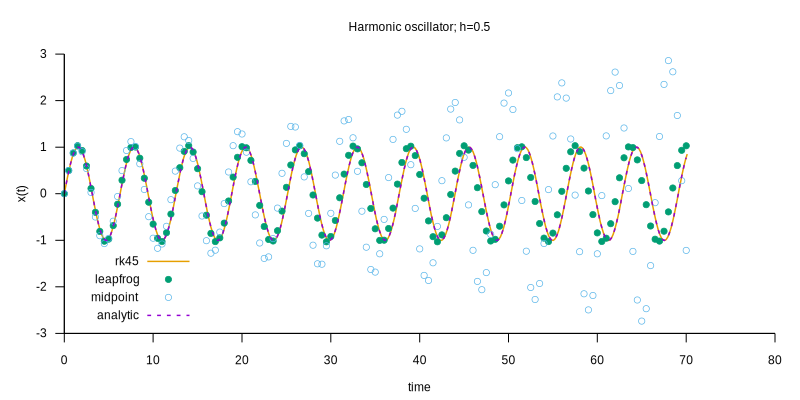

- : unit = ()


In [8]:
Juplot.draw ~fmt:`svg ~size:(800,400) (myplot Maths.sin sin_ic 0.0 70.0 0.5)

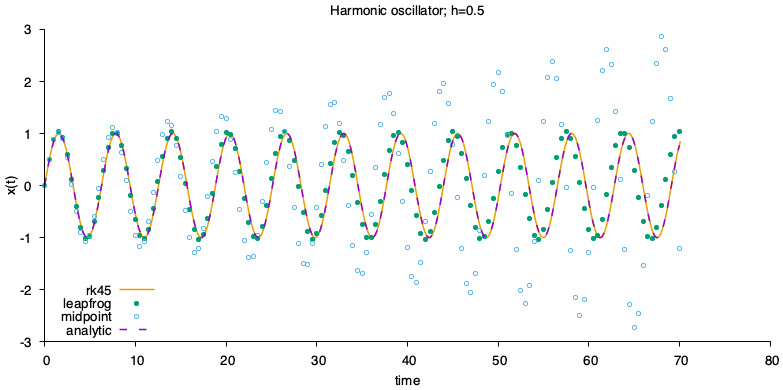

- : unit = ()


In [9]:
Juplot.draw ~fmt:`png ~size:(800,400) (myplot Maths.sin sin_ic 0.0 70.0 0.5)

In [10]:
let trk, solrk = Owl_ode.(
    Ode.odeint (module Native.D.RK4) oscillator (IC.to_initial sin_ic) (T1{t0=0.0; duration=70.0; dt=0.01}) ()
) in
Mat.((row solrk 0) - (map Maths.sin trk)) |> Mat.map abs_float |> Mat.max' |> Maths.log10
|> fun e -> "Log of worse error for RK4: " ^ string_of_float e

- : string = "Log of worse error for RK4: -8.23962759303"
